In [1]:
import pandas as pd

def load_coffee_data():
    csv_path = "mean_rgb_data.csv"
    return pd.read_csv(csv_path)


Vendo a estrutura das primeiras 5 linhas do dataset usando o método `head()`.

In [2]:
coffee = load_coffee_data()
coffee.head()

,Sample,R,G,B,Class
0,1,173,160,150,Immature
1,2,178,165,153,Immature
2,3,164,154,146,Immature
3,4,167,155,147,Immature
4,5,172,161,152,Immature


Verificando a estrutura do dataset.

In [3]:
coffee.shape # 180 linhas, 5 colunas

(180, 5)

O método `info()` é usado para se obter uma rápida descrição dos dados: número de linhas, tipo dos atributos e número de valores não-nulos.

In [4]:
coffee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Sample  180 non-null    int64 
 1   R       180 non-null    int64 
 2   G       180 non-null    int64 
 3   B       180 non-null    int64 
 4   Class   180 non-null    object
dtypes: int64(4), object(1)
memory usage: 7.2+ KB


Vendo quais categorias existem usando o método `value_counts()`.

In [5]:
coffee['Class'].value_counts()

Class
Immature    90
Mature      90
Name: count, dtype: int64

O método `describe()` mostra um resumo dos atributos numéricos.

In [6]:
coffee.describe()

,Sample,R,G,B
count,180.000000,180.000000,180.000000,180.000000
mean,90.500000,174.705556,158.450000,147.033333
std,52.105662,7.783881,6.802296,7.472781
min,1.000000,151.000000,141.000000,126.000000
25%,45.750000,169.750000,153.750000,141.750000
50%,90.500000,175.000000,159.000000,147.000000
75%,135.250000,180.250000,163.000000,153.000000
max,180.000000,189.000000,174.000000,165.000000


Uma maneira rápida de conhecer os dados tratados é plotando um histograma de cada atributo numérico. O método `hist()` pode fazer isso.

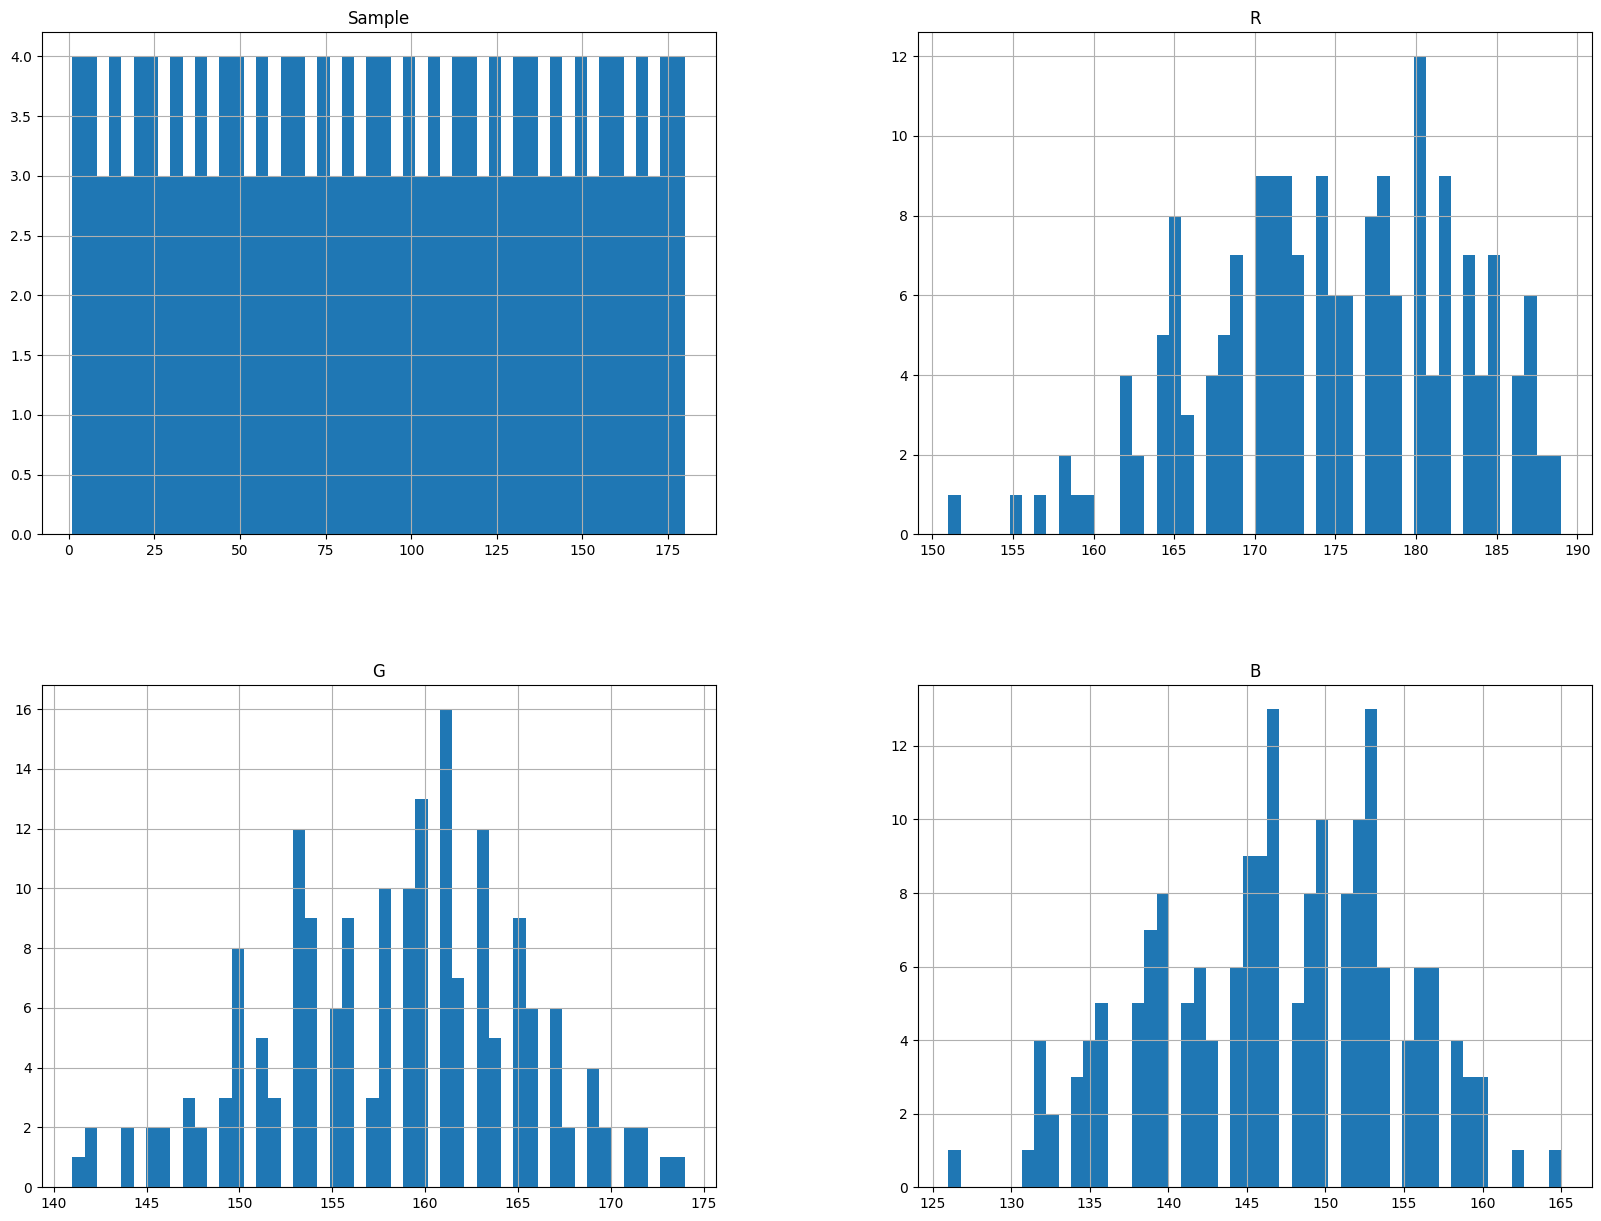

In [7]:
import matplotlib.pyplot as plt

coffee.hist(bins=50, figsize=(20,15))
plt.show()

Quanto à representatividade dos dados, é ideal ter datasets equilibrados para obter-se melhores resultados. Nesse caso, podemos aplicar uma lógica de estratificação do dataset na categoria "Class", equilibrando-o no que tange à quantidade de amostras maduras e imaturas. Nesse caso, para uma relação de 80/20 (treino/teste), espera-se 80 amostras maduras e 80 amostras imaturas para treino, totalizando 160 amostras, e 20 amostras maduras e 20 amostras imaturas para teste, totalizando 40 amostras. Para conseguir isso, vamos usar a biblioteca Scikitlearn. É válido ressaltar que não devemos ficar repetindo esse processo de construir os sets de treino e teste e executar o modelo muitas vezes, pois, por se tratar de um dataset pequeno, com o passar do tempo, o modelo de Machine Learning "verá" todo o dataset ainda na fase de treino, o que não queremos, pois não teríamos como testar de maneira fidedigna.

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

def split_train_test(data, test_ratio):
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio, random_state=42)

    for train_index, test_index in split.split(data, data["Class"]):
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]

    return train_set, test_set

train_set, test_set = split_train_test(coffee, 0.2)
print('Tamanho do set de treinamento: {}'.format(len(train_set)))
print('Tamanho do set de teste: {}'.format(len(test_set)))

Tamanho do set de treinamento: 144
Tamanho do set de teste: 36


In [9]:
print('SET DE TREINO \n')
train_set['Class'].value_counts()

SET DE TREINO 



Class
Immature    72
Mature      72
Name: count, dtype: int64

In [10]:
print('SET DE TESTE \n')
test_set['Class'].value_counts()

SET DE TESTE 



Class
Immature    18
Mature      18
Name: count, dtype: int64

Pronto! Agora conhecemos a estutura básica do nosso dataset e criamos os sets de treino e teste estratificados para prosseguirmos o estudo.

Tendo validado a acurácia do modelo para o dataset proposto, podemos seguir para uma implementação em texto estruturado (Python) para facilitar o deployment em hardware embarcado!

In [11]:
from sklearn.svm import SVC # Support Vector Classifier
from sklearn.metrics import accuracy_score # Funcao do scikit-learn usada para calcular a acuracia da precicao dos modelos

Agora vamos preparar os dados. Lembrando da teoria de SVM, precisamos identificar os parâmetros e a classe (label) a ser classificada.

In [12]:
x_train = train_set[['R', 'G', 'B']]
y_train = train_set['Class']

x_test = test_set[['R', 'G', 'B']]
y_test = test_set['Class']

Agora basta criar e treinar o modelo de Quadratic SVM (QSVM).

In [13]:
svm_model = SVC(kernel='poly', degree=2)
svm_model.fit(x_train, y_train)

SVC(degree=2, kernel='poly')

Aplicando as predições e avaliando o modelo:

In [14]:
y_pred = svm_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print('Acurácia: {}'.format(accuracy))

Acurácia: 0.9722222222222222


Como pudemos observar, o teste do modelo programado em Python resultou na mesma acurácia do teste feito no MATLAB anteriormente. Assim, validamos o modelo proposto pelo [artigo-base](http://www.warse.org/IJETER/static/pdf/file/ijeter22872020.pdf) nas mesmas condições dos autores e agora na condição de trabalho que propõe o presente artigo. Com o modelo treinado, basta salvá-lo e portá-lo para um Raspberry Pi.

In [15]:
from joblib import dump # Funcao usada para salvar o modelo treinado em um arquivo especificando um nome

dump(svm_model, 'QSVM_TREINADO_NOVO_DATASET.joblib')

['QSVM_TREINADO_NOVO_DATASET.joblib']

Vamos salvar, também, o set de teste em um arquivo `.csv` para facilitar a operação no Raspberry Pi.

In [16]:
test_set.to_csv('QSVM_TEST_SET_NOVO_DATASET.csv', index=False) # index=False faz com que a coluna do indice nao seja incluida no arquivo salvo